In [ ]:
import GMMfunction as GMM
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import subprocess # inkspace
from scipy.stats import gaussian_kde
# import seaborn as sns
# sns.set_style('white')
np.random.seed(40)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 18
})

# MACos only
# import os
# os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"


In [ ]:
M, DX, DY, N, noise_level = (2, 2, 2, 10000, 8) # number of individual gaussians, dimension of the data, number of samples
# mus = GMM.generate_mu_list(M, DX)
# sigmas = GMM.generate_sigma_list(M, DX)
mus = [np.array([1, 2]), np.array([8, 10])]
sigmas = [np.array([[1, 0], [0, 2]]), np.array([[2, 1], [1, 1]])]
x = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, N).T

A = np.random.randn(DY, DX)
Nsigma, n = GMM.generate_noise(noise_level, DY, N)

y = A @ x + n

train_samples_x = x[:, :int(x.shape[-1] * 0.8)]
test_samples_x  = x[:, int(x.shape[-1] * 0.8):]
train_samples_y = y[:, :int(y.shape[-1] * 0.8)]
test_samples_y  = y[:, int(y.shape[-1] * 0.8):]

Text(0.5, 1.0, '$p(x)$ vs $p(x|y)$')

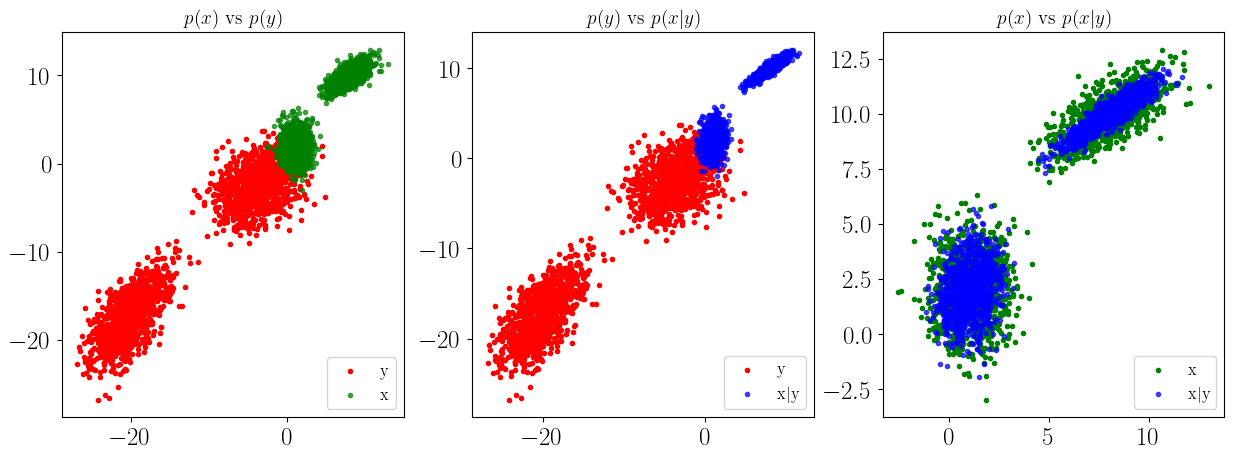

In [3]:

%matplotlib inline
mu1_real_res = GMM.mu1_real(test_samples_y, A, mus, sigmas, Nsigma)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
# sns.scatterplot(test_samples_y, marker='.', color='red', alpha=1, label='y')
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=0.7, label='x')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(y)$', fontsize=14)

plt.subplot(1, 3, 2)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(y)$ vs $p(x|y)$', fontsize=14)

plt.subplot(1, 3, 3)
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=1, label='x')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(x|y)$', fontsize=14)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


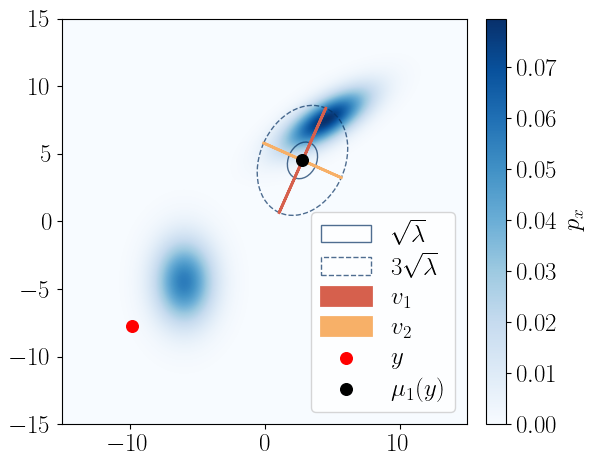

In [4]:
n_ev = 2 # number of eigenvectors

plt.figure(figsize=(6,5))

[XX, YY] = np.meshgrid(np.linspace(-5,15,200), np.linspace(-5,15,200))

xs = np.stack([XX.ravel(), YY.ravel()])
GMM_pdf, GMM_mean = GMM.px_pdf_real(xs, mus, sigmas)

x_1 = GMM_mean.reshape(-1,1)
# x_1 = np.array([-10, -10]).reshape(2,1).astype(np.float64)

y_1 = A @ x_1 + GMM.generate_noise(noise_level, DY, 1)[1]


first_moments, second_moments, eigvecs, eigvals, mmse = GMM.moment_calculation(y_1, A, mus, sigmas, Nsigma, n_ev)

c = plt.imshow(GMM_pdf.reshape(XX.shape), cmap='Blues', origin='lower', extent=[-15, 15, -15, 15], interpolation='bilinear')

angle = np.arctan2(eigvecs[1,0], eigvecs[0,0]) * 180 / np.pi
ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', label='$\sqrt{\lambda}$')
plt.gca().add_artist(ellipse)

threesig_ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 6 * np.sqrt(eigvals[0]), 6 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', linestyle='--', label='$3\sqrt{\lambda}$')
plt.gca().add_artist(threesig_ellipse)

eigvecs /= np.linalg.norm(eigvecs, axis=0, keepdims=True)
eigvals = np.abs(eigvals)

plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2, label='$v_1$')
plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), -eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2)
if n_ev > 1:
    plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2, label='$v_2$')
    plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), -eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2)
plt.scatter(y_1[0], y_1[1], marker='o', color='red', label='$y$', s=70)
plt.scatter(mmse[0], mmse[1], marker='o', color='black', label='$\mu_1(y)$', s=70)

y_up = (mmse + 3 * np.sqrt(eigvals) * eigvecs)[:,0]
y_down = (mmse - 3 * np.sqrt(eigvals) * eigvecs)[:, 0]

plt.colorbar(c, ax=plt.gca(), label="$p_x$", fraction=0.046, pad=0.04)

plt.legend(loc='lower right', labelspacing=0.3)
plt.tight_layout()
ylimmin, ylimmax = plt.gca().get_ylim()
xlimmin, xlimmax = plt.gca().get_xlim()
os.makedirs('Figures', exist_ok=True)
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.pdf'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.svg'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.eps'), dpi=500, bbox_inches='tight')
subprocess.call('inkscape Figures/GMM_Example_theoretical.svg --export-type="emf"',shell=True)

plt.show()

In [5]:
from scipy.stats import gaussian_kde, norm
h=1e-5
A_invT = np.linalg.pinv(A.T)
third_moments = []
fourth_moments = []
for i in range(n_ev):
    first_term = GMM.mu1_real(y_1 + A @ eigvecs[:, i].reshape(2,1) * 2 * h,  A, mus, sigmas, Nsigma)
    second_term = GMM.mu1_real(y_1 + A @ eigvecs[:, i].reshape(2,1) * h, A, mus, sigmas, Nsigma)
    third_term = GMM.mu1_real(y_1, A, mus, sigmas, Nsigma)
    fourth_term = GMM.mu1_real(y_1 - A @ eigvecs[:, i].reshape(2,1) * h, A, mus, sigmas, Nsigma)
    
    deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

    fourth_moments.append((noise_level ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

    deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
    third_moments.append((noise_level ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

third_moments = np.array(third_moments)
fourth_moments = np.array(fourth_moments)


print(f'vmu1 = {first_moments[:,0]};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')

# print(first_moments.shape)
mean = (first_moments.reshape(-1, 1).T @ A_invT)
mean = first_moments[0][0]
variance = (second_moments)[0]
std_dev = np.sqrt(variance)

skewness = ((third_moments)[0] - 3 * mean * variance - mean**3) / (std_dev ** 3)
kurtosis = ((fourth_moments)[0] - 4 * mean * (third_moments)[0] + 6 * mean**2 * variance + mean**4) / (std_dev ** 4) - 3





vmu1 = [-5.26100470e-05 -7.12770274e-06];
vmu2 = [1.98567844 1.09755227];
vmu3 = [-3.82142421  0.07967317];
vmu4 = [ 3.89229074 21.33746174];
noisy_sample = [-9.848383808283296; -7.738754937423813];
mmse_sample = [2.7950465732867373; 4.51374861580992];
real_sample = [4.5 6.0];
evs = [[-0.40755698 -0.91317978]
 [-0.91317978  0.40755698]];


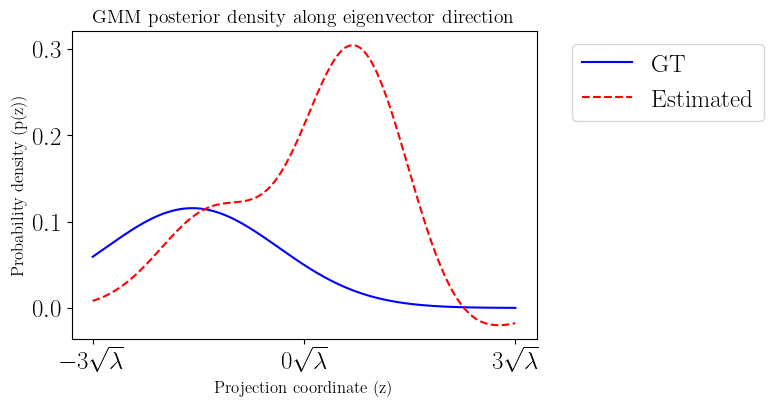

In [6]:
# project xs on the first eigenvector
proj = np.dot(eigvecs[0].T, xs)

kde = gaussian_kde(proj.flatten(), weights=GMM_pdf)
lambda_sqrt = np.sqrt(eigvals[0])
z_range = np.linspace(first_moments[0][0] - 3 * lambda_sqrt, first_moments[0][0] + 3 * lambda_sqrt, 200)
density = kde(z_range)
z = (z_range - mean) / std_dev
H3 = z**3 - 3 * z
H4 = z**4 - 6 * z**2 + 3
pdf_estimate = norm.pdf(z_range, mean, std_dev) * (1 + (skewness / 6) * H3 + (kurtosis / 24) * H4)


plt.figure(figsize=(6, 4))
plt.plot(z_range, density, label="GT", color='blue')
plt.plot(z_range, pdf_estimate, label="Estimated", color='red', linestyle="dashed")

xticks = np.linspace(first_moments[0][0] - 3 * lambda_sqrt, first_moments[0][0] + 3 * lambda_sqrt, 3)
xticklabels = [rf"${(x - first_moments[0][0]) / lambda_sqrt:.0f} \sqrt{{\lambda}}$" for x in xticks]

plt.xticks(xticks, xticklabels)


plt.xlabel("Projection coordinate (z)", fontsize=12)
plt.ylabel("Probability density (p(z))", fontsize=12)
plt.title("GMM posterior density along eigenvector direction", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()